In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sqlite3
import seaborn as sns

sns.set(style='white', palette="Set2", color_codes=False)
sns.set_style("ticks")

%matplotlib inline

In [2]:
def get_dataframes(query, databases):
    dataframes = []
    for database in databases:
        db = sqlite3.connect(database)
        dataframes += [pd.read_sql_query(query, db)]
    return pd.concat(dataframes)

In [3]:
query = 'select time, task_type, tag, app from tasks'
databases = [
             'data.db', 
             ]
tasks = get_dataframes(query, databases)
tasks.head()

,time,task_type,tag,app
0,1598398444.7675135;1598398446.6210368;15983988...,mapper,sharedfs,wordcount
1,1598398444.9490175;1598398446.8451445;15983988...,mapper,sharedfs,wordcount
2,1598398453.8023963;1598398455.7503765;15983996...,mapper,sharedfs,wordcount
3,1598398445.282681;1598398447.1083984;159839960...,mapper,sharedfs,wordcount
4,1598398453.8161354;1598398455.8094254;15983988...,mapper,sharedfs,wordcount


In [4]:
tasks[['start', 'end reading', 'end processing', 'end']] = tasks['time'].str.split(";", expand=True)
tasks['Data reading'] = tasks['end reading'].astype(float) - tasks['start'].astype(float)
tasks['Processing'] = tasks['end processing'].astype(float) - tasks['end reading'].astype(float)
tasks['Data writing'] = tasks['end'].astype(float) - tasks['end processing'].astype(float)
tasks

,time,task_type,tag,app,start,end reading,end processing,end,Data reading,Processing,Data writing
0,1598398444.7675135;1598398446.6210368;15983988...,mapper,sharedfs,wordcount,1598398444.7675135,1598398446.6210368,1598398839.7686245,1598398846.0830152,1.853523,393.147588,6.314391
1,1598398444.9490175;1598398446.8451445;15983988...,mapper,sharedfs,wordcount,1598398444.9490175,1598398446.8451445,1598398823.338788,1598398829.3971126,1.896127,376.493644,6.058325
2,1598398453.8023963;1598398455.7503765;15983996...,mapper,sharedfs,wordcount,1598398453.8023963,1598398455.7503765,1598399631.1153166,1598399649.5888946,1.947980,1175.364940,18.473578
3,1598398445.282681;1598398447.1083984;159839960...,mapper,sharedfs,wordcount,1598398445.282681,1598398447.1083984,1598399600.944291,1598399617.550775,1.825717,1153.835893,16.606484
4,1598398453.8161354;1598398455.8094254;15983988...,mapper,sharedfs,wordcount,1598398453.8161354,1598398455.8094254,1598398827.92276,1598398834.7881877,1.993290,372.113335,6.865428
...,...,...,...,...,...,...,...,...,...,...,...
3040,1598469491.8024178;1598469496.9605904;15984695...,reducer,redis,sort,1598469491.8024178,1598469496.9605904,1598469504.3260396,1598469508.5582187,5.158173,7.365449,4.232179
3041,1598469491.9540353;1598469512.7081573;15984696...,reducer,redis,sort,1598469491.9540353,1598469512.7081573,1598469622.4751503,1598469667.9912899,20.754122,109.766993,45.516140
3042,1598469492.1456985;1598469502.1244214;15984695...,reducer,redis,sort,1598469492.1456985,1598469502.1244214,1598469544.3310902,1598469564.3818905,9.978723,42.206669,20.050800
3043,1598469492.350836;1598469495.3214242;159846949...,reducer,redis,sort,1598469492.350836,1598469495.3214242,1598469495.4419472,1598469495.6262786,2.970588,0.120523,0.184331


[[2.7117374792695044, 2.7354282695800065], [570.269877287373, 593.7028456658124], [3.554938383027911, 8.152463708817958], [33.38548582792282, 43.40179215669632], [26.938437354564666, 29.813334155082703], [27.61498341560364, 29.676068937778474]]
[2.7117374792695044, 2.7354282695800065]
[572.9816147666425, 596.4382739353924]
[576.5365531496703, 604.5907376442104]
[609.9220389775932, 647.9925298009067]
[636.8604763321579, 677.8058639559894]
[664.4754597477615, 707.4819328937679]


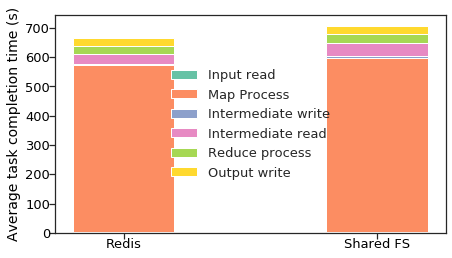

In [5]:
apps = ['wordcount']

labels = ['Input read', 'Map Process', 'Intermediate write',
          'Intermediate read', 'Reduce process', 'Output write']

methods = {'redis': 'Redis',
           'sharedfs': "Shared FS",
}

fig, ax = plt.subplots(1, len(apps), figsize=(7,4))

for i, app in enumerate(apps):
    markers = ['o', 's', 'p', '^', 'd', 'X']
    marker_sizes = [6, 7, 7, 7, 7, 7, 6]
    #ax = axes[i]
    data = [[] for _ in range(6)]
    for method in methods:
        mapper_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'mapper') & (tasks['app'] == app)
        reducer_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'reducer') & (tasks['app'] == app)
        mapper_df = tasks[mapper_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        reducer_df = tasks[reducer_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        mapper_means = mapper_df.groupby('tag', as_index=False).mean()
        reducer_means = reducer_df.groupby('tag', as_index=False).mean()
        columns = ['Data reading', 'Processing', 'Data writing']
        for j, column in enumerate(columns):
            data[j].append(mapper_means.iloc[0][column])
            data[j+len(columns)].append(reducer_means.iloc[0][column])
    print(data)
    log = False
    width = 0.4
    cur = [0] * len(data[0])
    for j in range(6):
        if j == 0:
            ax.bar(list(methods.values()), data[j], width=width,
                   label=labels[j], log=log)
        else:
            ax.bar(list(methods.values()), data[j], width=width,
                   bottom=cur, label=labels[j], log=log)
        cur = [sum(x) for x in zip(cur, data[j])]
        print(cur)

#     ax.set_xscale('log', basex=10)
    #ax.set_title(app.capitalize(), fontsize=14)
    ax.set_ylabel('Average task completion time (s)', fontsize=14, color='black')
#     ax.set_xlabel('Size (bytes)', fontsize=14, color='black')


# #         box = ax.get_position()
#     ax.set_ylim(0.001, 100)
#     #ax.set_xlim(0.001, 10)
    ax.legend(loc='center',fontsize=13, frameon=False)
    ax.tick_params(axis='both', which='major', pad=-1, labelsize=13, labelcolor='black')

# plt.tight_layout()
plt.savefig('{}.png'.format(apps[0]), bbox_inches = "tight", dpi=300)

[[4.7099843492362705, 4.874070133268833], [14.43309537965029, 14.33707543052733], [4.272079411617995, 2.3176430337131024], [11.370142741203308, 41.76904098033905], [49.60874440670013, 46.631559300422666], [21.14799554347992, 16.98128698348999]]
[4.7099843492362705, 4.874070133268833]
[19.143079728886562, 19.211145563796162]
[23.415159140504556, 21.528788597509266]
[34.785301881707866, 63.29782957784832]
[84.39404628840799, 109.92938887827098]
[105.54204183188791, 126.91067586176098]


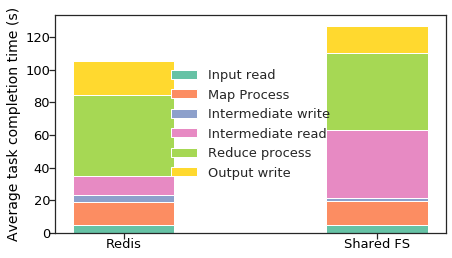

In [6]:
apps = ['sort']

labels = ['Input read', 'Map Process', 'Intermediate write',
          'Intermediate read', 'Reduce process', 'Output write']

methods = {'redis': 'Redis',
           'sharedfs': "Shared FS",
}

fig, ax = plt.subplots(1, len(apps), figsize=(7,4))

for i, app in enumerate(apps):
    markers = ['o', 's', 'p', '^', 'd', 'X']
    marker_sizes = [6, 7, 7, 7, 7, 7, 6]
    #ax = axes[i]
    data = [[] for _ in range(6)]
    for method in methods:
        mapper_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'mapper') & (tasks['app'] == app)
        reducer_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'reducer') & (tasks['app'] == app)
        mapper_df = tasks[mapper_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        reducer_df = tasks[reducer_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        mapper_means = mapper_df.groupby('tag', as_index=False).mean()
        reducer_means = reducer_df.groupby('tag', as_index=False).mean()
        columns = ['Data reading', 'Processing', 'Data writing']
        for j, column in enumerate(columns):
            data[j].append(mapper_means.iloc[0][column])
            data[j+len(columns)].append(reducer_means.iloc[0][column])
    print(data)
    log = False
    width = 0.4
    cur = [0] * len(data[0])
    for j in range(6):
        if j == 0:
            ax.bar(list(methods.values()), data[j], width=width,
                   label=labels[j], log=log)
        else:
            ax.bar(list(methods.values()), data[j], width=width,
                   bottom=cur, label=labels[j], log=log)
        cur = [sum(x) for x in zip(cur, data[j])]
        print(cur)

#     ax.set_xscale('log', basex=10)
    #ax.set_title(app.capitalize(), fontsize=14)
    ax.set_ylabel('Average task completion time (s)', fontsize=14, color='black')
#     ax.set_xlabel('Size (bytes)', fontsize=14, color='black')


# #         box = ax.get_position()
#     ax.set_ylim(0.001, 100)
#     #ax.set_xlim(0.001, 10)
    ax.legend(loc='center',fontsize=13, frameon=False)
    ax.tick_params(axis='both', which='major', pad=-1, labelsize=13, labelcolor='black')

# plt.tight_layout()
plt.savefig('{}.png'.format(apps[0]), bbox_inches = "tight", dpi=300)

[[2.7117374792695044, 2.7354282695800065], [570.269877287373, 593.7028456658124], [3.554938383027911, 8.152463708817958], [33.38548582792282, 43.40179215669632], [26.938437354564666, 29.813334155082703], [27.61498341560364, 29.676068937778474]]
[2.7117374792695044, 2.7354282695800065]
[572.9816147666425, 596.4382739353924]
[576.5365531496703, 604.5907376442104]
[609.9220389775932, 647.9925298009067]
[636.8604763321579, 677.8058639559894]
[664.4754597477615, 707.4819328937679]
[[4.7099843492362705, 4.874070133268833], [14.43309537965029, 14.33707543052733], [4.272079411617995, 2.3176430337131024], [11.370142741203308, 41.76904098033905], [49.60874440670013, 46.631559300422666], [21.14799554347992, 16.98128698348999]]
[4.7099843492362705, 4.874070133268833]
[19.143079728886562, 19.211145563796162]
[23.415159140504556, 21.528788597509266]
[34.785301881707866, 63.29782957784832]
[84.39404628840799, 109.92938887827098]
[105.54204183188791, 126.91067586176098]


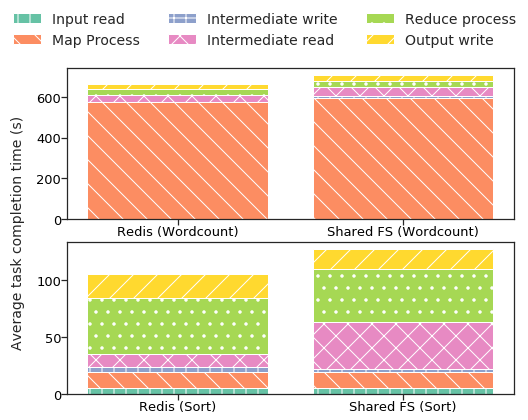

In [45]:
apps = ['Wordcount', 'Sort']

labels = ['Input read', 'Map Process', 'Intermediate write',
          'Intermediate read', 'Reduce process', 'Output write']

methods = {'redis': 'Redis',
           'sharedfs': "Shared FS",
}

fig, axes = plt.subplots(len(apps), 1, figsize=(8,6))

for i, app in enumerate(apps):
    markers = ['o', 's', 'p', '^', 'd', 'X']
    hatches = ['|', "\\" , "+" , "x", ".",  "/" ]
    marker_sizes = [6, 7, 7, 7, 7, 7, 6]
    ax = axes[i]
    data = [[] for _ in range(6)]
    for method in methods:
        mapper_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'mapper') & (tasks['app'] == app.lower())
        reducer_cuts = (tasks['tag'] == method) & (tasks['task_type'] == 'reducer') & (tasks['app'] == app.lower())
        mapper_df = tasks[mapper_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        reducer_df = tasks[reducer_cuts][['tag', 'Data reading', 'Processing', 'Data writing']]
        mapper_means = mapper_df.groupby('tag', as_index=False).mean()
        reducer_means = reducer_df.groupby('tag', as_index=False).mean()
        columns = ['Data reading', 'Processing', 'Data writing']
        for j, column in enumerate(columns):
            data[j].append(mapper_means.iloc[0][column])
            data[j+len(columns)].append(reducer_means.iloc[0][column])
    print(data)
    log = False
    width = 0.8
    cur = [0] * len(data[0])
    for j in range(6):
        if j == 0:
            ax.bar(list(methods.values()), data[j], width=width,
                   label=labels[j], log=log, hatch=hatches[j])
        else:
            ax.bar(list(methods.values()), data[j], width=width,
                   bottom=cur, label=labels[j], log=log, hatch=hatches[j])
        cur = [sum(x) for x in zip(cur, data[j])]
        print(cur)

#     ax.set_xscale('log', basex=10)
    #ax.set_title(app.capitalize(), fontsize=14)
    #ax.set_ylabel('Average task completion time (s)', fontsize=14, color='black')
#     ax.set_xlabel('Size (bytes)', fontsize=14, color='black')


# #         box = ax.get_position()
#     ax.set_ylim(0.001, 100)
#     #ax.set_xlim(0.001, 10)
    ax.tick_params(axis='both', which='major', pad=0, labelsize=13, labelcolor='black')
    #ax.set_ylabel('Average task completion time (s)', fontsize=14, color='black')
    ax.set_xticklabels(['Redis ({})'.format(app), 'Shared FS ({})'.format(app)])
    
fig.text(0.04, 0.5, 'Average task completion time (s)', ha='center', va='center', rotation='vertical', fontsize=14)
ax.legend(bbox_to_anchor=(-0.15, 2.6), loc='upper left',
          ncol=3,
          fontsize=14, frameon=False,
          #bbox_to_anchor=(0.5, 1.01),
         )
plt.subplots_adjust(hspace = 0.15)
# plt.tight_layout()
plt.savefig('mapreduce-redis.pdf', bbox_inches = "tight", dpi=300)